In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from skimage.metrics import structural_similarity, peak_signal_noise_ratio, mean_squared_error
from IPython import display
import time

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


In [3]:
# The data is in https://drive.google.com/file/d/1n9gjLCxzFe8N2QbHeZkDtswlSdNyJpEs/view?usp=drive_link
test_data = np.load("test_dataset.npy")
print("Test data shape: ", test_data.shape)
np.max(test_data)

Test data shape:  (4, 320, 256, 256)


np.float32(1.0)

In [4]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.down1 = nn.Sequential(nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2)

        self.middle = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.Conv2d(256, 256, 3, padding=1), nn.ReLU())

        self.up1 = nn.Sequential(nn.ConvTranspose2d(256, 128, 2, stride=2), nn.ReLU())
        self.conv_up1 = nn.Sequential(nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())

        self.up2 = nn.Sequential(nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU())
        self.conv_up2 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        down1 = self.down1(x)
        pool1 = self.pool1(down1)
        down2 = self.down2(pool1)
        pool2 = self.pool2(down2)

        middle = self.middle(pool2)

        up1 = self.up1(middle)
        up1 = torch.cat((up1, down2), dim=1)
        up1 = self.conv_up1(up1)

        up2 = self.up2(up1)
        up2 = torch.cat((up2, down1), dim=1)
        up2 = self.conv_up2(up2)

        return self.final(up2)

In [5]:
'''
Reading the pretrained parameters
'''
model = SimpleUNet()
# The pretrained model is in https://drive.google.com/file/d/16W_aeHeB-yBHSFRfo1ILJh3DbahkUiRT/view?usp=drive_link
state_dict = torch.load('trained_model_unconditional.pth', map_location=torch.device('cpu'), weights_only=True)
model.load_state_dict(state_dict)
model.to(device)
model.eval();

In [9]:
def denoise(guidance, model, K, beta_min = 1e-4, beta_max = 0.02, steps=[1000], output_freq=10, show_intermediate_output=False):
    for i in range(K):
        betas = torch.linspace(beta_min, beta_max, steps[i]).to(device)
        alphas = 1 - betas
        alphas_cumprod = torch.cumprod(alphas, axis=0)
        epsilon = torch.randn_like(guidance).to(device)
        x_t = torch.sqrt(alphas_cumprod[steps[i]-1]) * guidance + \
        torch.sqrt(1 - alphas_cumprod[steps[i]-1]) * epsilon
        for t in reversed(range(1, steps[i]+1)):
            assert x_t.shape[1] == 1, f"Error: The channel of x_t != 1."  # Make sure the input is a single channel snapshot
            if show_intermediate_output and (t%output_freq == 0 or t == 1):
                plt.imshow(x_t.squeeze().cpu())
                display.display(plt.gcf())
                display.clear_output(wait=True)
                time.sleep(0.01)
                
            # Calculate the parameters
            alpha_t_bar = alphas_cumprod[t-1]
            beta_t = betas[t-1]
            alpha_t = alphas[t-1]
            # Predict the noise using the model
            with torch.no_grad():
                epsilon_theta = model(x_t)

            # Make sure the output of the model (the predicted noise) has a single channel
            assert epsilon_theta.shape[1] == 1, "Error: The channel of epsilon_theta != 1."
            # Calculate the mean of the previous step in the backward process of diffusion model
            mean = (1 / torch.sqrt(alpha_t)) * (x_t - (beta_t / torch.sqrt(1 - alpha_t_bar)) * epsilon_theta)
            # Add noise for all but the last step (strictly follow the algorithm)
            if t > 1:
                # z = torch.randn_like(x_t).to(device)
                z = torch.randn_like(x_t).to(device)
                x_t = mean + torch.sqrt(beta_t) * z
            else:
                x_t = mean

        guidance = x_t
        #plt.show()
    return x_t

(4, 20, 1024)


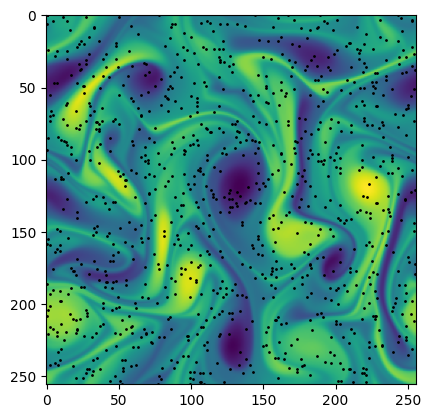

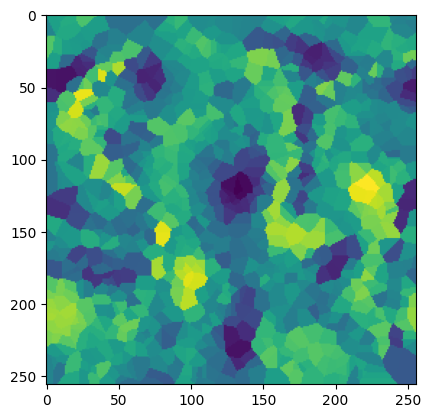

In [10]:
#Randomly choose a fixed percentage of points from the test snapshot
percentage = 1.5625
factor = percentage/100
start_idx = 80
end_idx = 100
N = int(256**2 * factor)
test_snapshots = test_data[:, start_idx : end_idx]
nx = np.random.randint(0, 256, (N,))
ny = np.random.randint(0, 256, (N,))
sparse_measurement =  test_snapshots[..., nx, ny]

#Nearest neighbor interpolation
xx,yy = np.meshgrid(np.arange(256), np.arange(256))
coordinates = np.vstack((nx, ny)).T
#interpolated_sparse_measurement = interpolate.griddata(coordinates, sparse_measurement, (xx,yy), method='nearest').T
sparse_measurement_list = []
print(sparse_measurement.shape)
for i in range(sparse_measurement.shape[0]):
    sl_list = []
    for j in range(sparse_measurement.shape[1]):
        sl_list.append(interpolate.griddata(coordinates, sparse_measurement[i,j], (xx,yy), method='nearest').T)
    sparse_measurement_list.append(sl_list)

interpolated_sparse_measurement = np.array(sparse_measurement_list)

#Visualize location of selected points and interpolated sparse measurements
figure,ax = plt.subplots()
figure2,ax2 = plt.subplots()
ax.imshow(test_snapshots[0,5])
mask = np.zeros((256, 256))
mask[nx, ny] = 1
ax.scatter(xx*mask, yy*mask, s=1, c="black")
ax2.imshow(interpolated_sparse_measurement[0, 5])

#Choose one of the four trajectories
trajectory = 3
sparse_measurement = torch.tensor(interpolated_sparse_measurement[trajectory],  dtype=torch.float32).unsqueeze(1).to(device)

K=2, S=100, 


KeyboardInterrupt: 

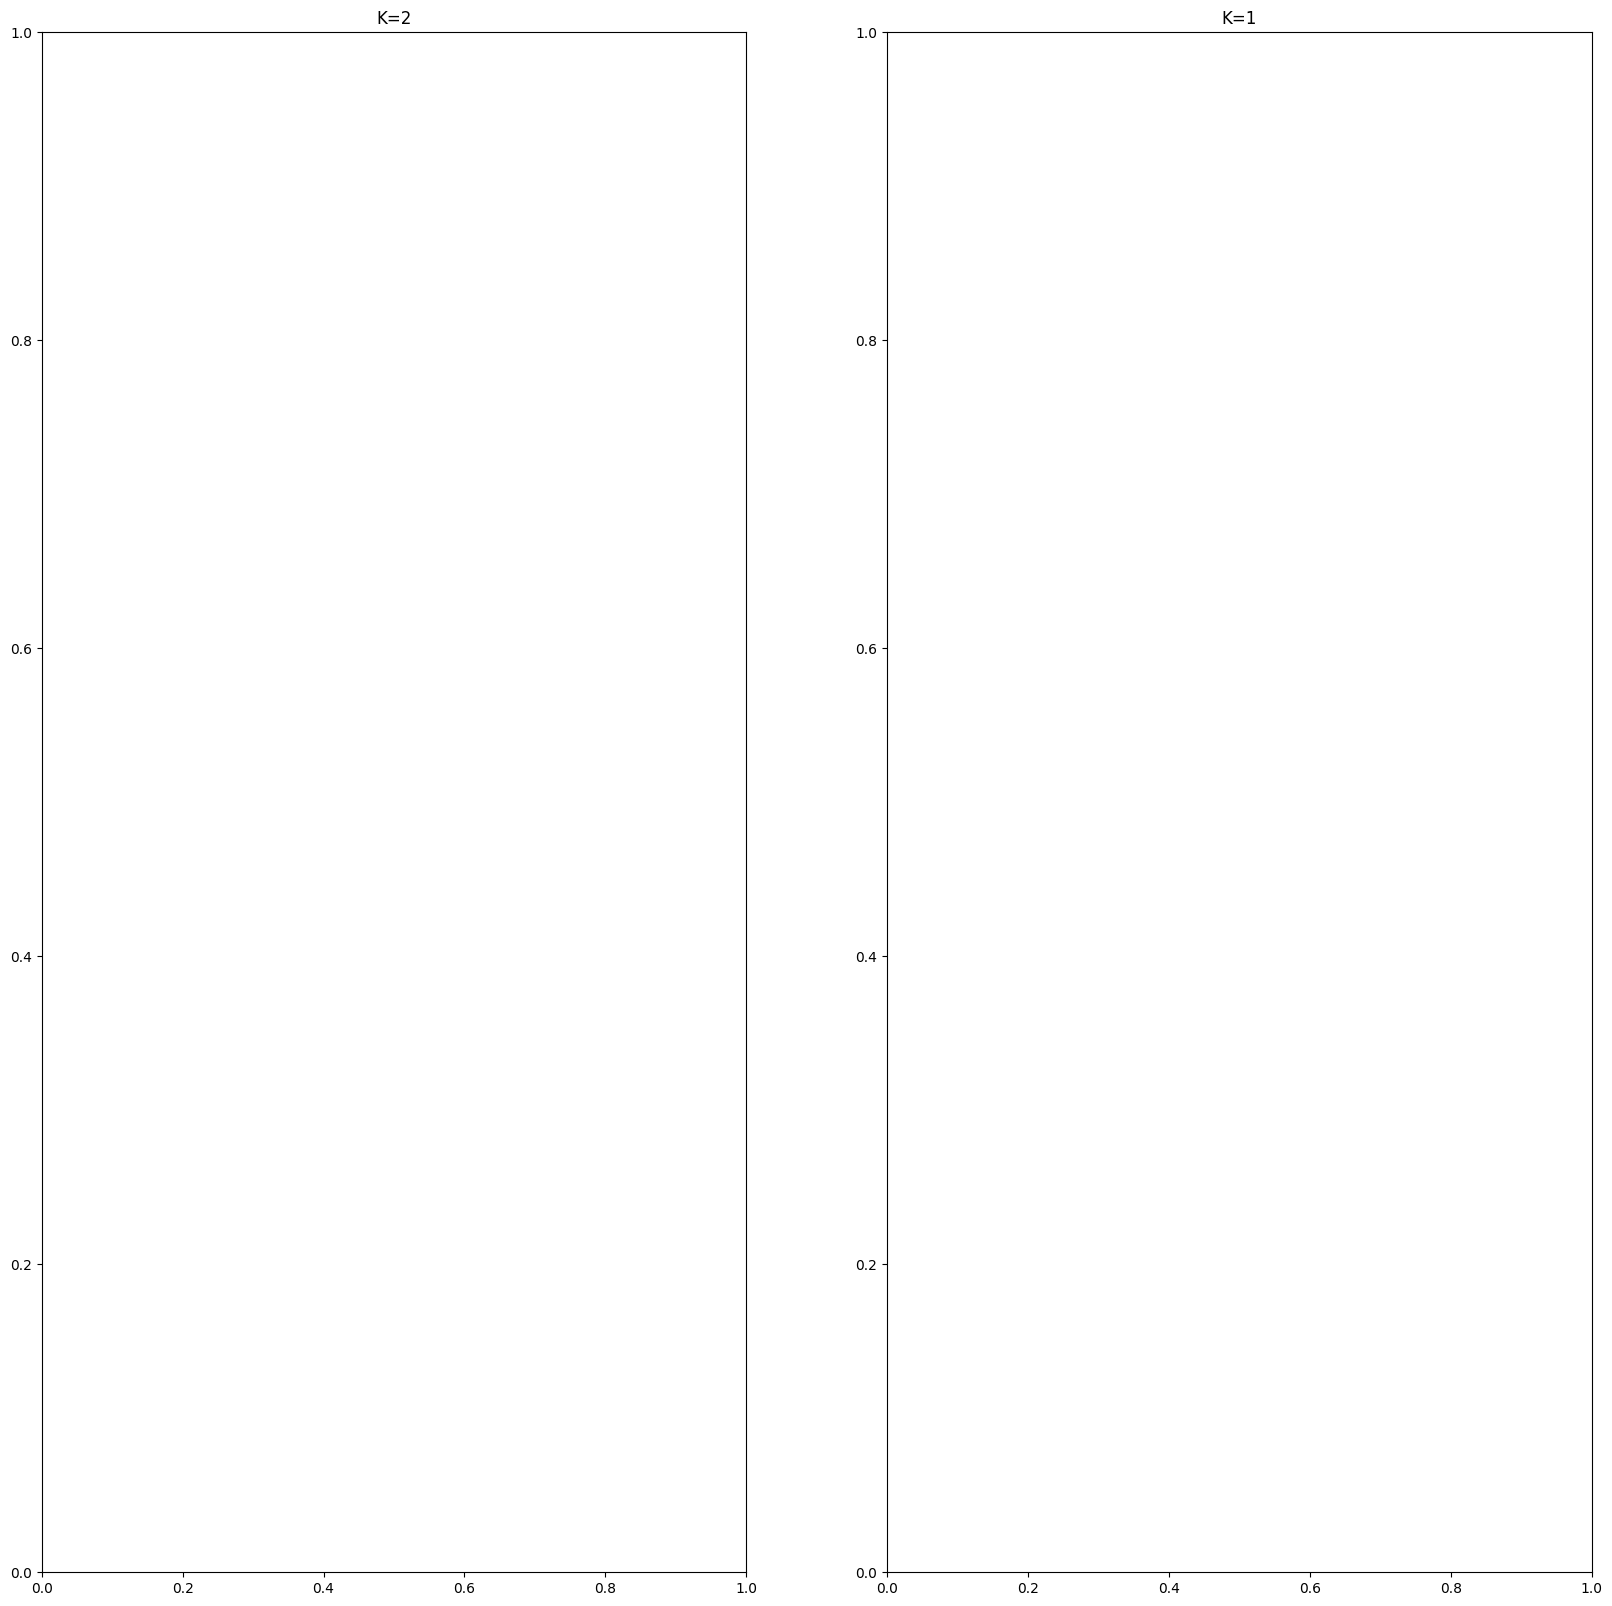

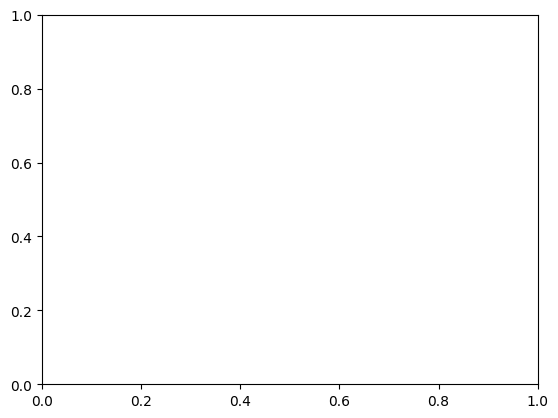

In [8]:
import os
from energy_spectrum import compute_tke_spectrum

#sparse_measurement = torch.tensor(interpolated_sparse_measurement, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)


def two_point_corr(field, axis=0):
    number_of_cells = field.shape[axis]
    mean = np.mean(field)
    field_prime = field - mean
    var = np.mean(field_prime * field_prime)
    f_corr = []
    for ii in range(number_of_cells // 2):
        f_corr_ii = np.mean(field_prime * np.roll(field_prime, shift=ii, axis=axis)) / var # longitudinal
        f_corr.append(f_corr_ii)
    f_corr = np.array(f_corr)
    return f_corr


def parametric(K,S, beta_max):
    two_point_corr_list = []
    energy_spetrum_list = []
    pdf_list = []
    bins_list = []
    vars = {"K" : K, "t" : S, "beta_max" : beta_max}
    if len(S) > 1:
        size = len(S)
        title = r"t"
        independent_var = "t"
    elif len(beta_max) > 1:
        size = len(beta_max)
        title = r"$\beta_{max}$"
        independent_var = "beta_max"
    elif len(K) > 1:
        size = len(K)
        title = r"K"
        independent_var = "K"

    fig_generated, ax_generated = plt.subplots(1,size, figsize=(20,20))
    fig_gt,ax_gt =  plt.subplots()
    for i in range(size):
        ax_generated[i].set_title(title + r"=" + str(vars[independent_var][i]))
    i = 0
    for s in S:
        for k in K:
                for beta in beta_max:
                    print(f"K={k}, S={s}, ")
                    path_K = os.path.join(path, "K_" + str(k))
                    path_K_str = path + "K_" + str(k)
                    if not os.path.exists(path_K):
                        os.makedirs(path_K)
                    steps = np.ones((k,), dtype=np.int16) * s
                    generated_image = denoise(sparse_measurement, model,steps=steps, K=k, beta_max=beta, output_freq=10).squeeze().detach().cpu().numpy()
                    ax_generated[i].imshow(generated_image[5])
                    two_point_corr_list.append(two_point_corr(generated_image, axis=1))
                    _,_, spectrum = compute_tke_spectrum(generated_image[5],1,1)
                    energy_spetrum_list.append(spectrum)
                    pdf, bins = np.histogram(generated_image.flatten(), bins=100)
                    pdf_list.append(pdf)
                    bins_list.append(bins)
                    i+=1
    ax_gt.imshow(test_snapshots[trajectory, 5])
    return np.array(two_point_corr_list), np.array(energy_spetrum_list), np.array(pdf_list), np.array(bins_list)

S = [100]
K = [2,1]
beta_max = [0.002]

path = "/home/baris/Documents/DDSim/baris-personal/sparse/"

two_point_corr_array, spectrum_generated_image, pdf, bins = parametric(K,S, beta_max)
figure, axis = plt.subplots()
#figure2, axis2 = plt.subplots()
figure3, axis3 = plt.subplots()
figure4, axis4 = plt.subplots()
axis4.set_xscale("log")
axis4.set_yscale("log")

nyquist, wave_numbers, spectrum_ground_truth = compute_tke_spectrum(test_snapshots[trajectory,5], 1,1)
_, _, spectrum_sparse = compute_tke_spectrum(sparse_measurement[5].squeeze().detach().cpu().numpy(), 1,1)

nyquist = int(nyquist/(2*np.pi))

pdf_ground_truth, bins_gt = np.histogram(test_snapshots[trajectory].flatten(), bins=100)
bins = bins.T
dx = (np.max(test_snapshots[trajectory]) - np.min(test_snapshots[trajectory]))/100
dx_generated = bins[1:] - bins[:-1]
pdf = pdf.T/(generated_image.size * dx_generated)
pdf_ground_truth = pdf_ground_truth/(test_snapshots[trajectory].size * dx)

two_point_corr_ground_truth = two_point_corr(test_snapshots[trajectory], axis=-2)




if len(S) > 1:
    legend = ["Ground Truth", r"$t=50$", r"$t=100$", r"$t=200$", r"$t=400$"]
    independent_var = "S"
elif len(beta_max) > 1:
    legend = ["Ground Truth", r"$\beta_{max}=0.02$", r"$\beta_{max}=0.002$"]
    independent_var = "beta_max"
elif len(K) > 1:
    legend = ["Ground Truth", r"$K=1$", r"$K=2$", r"$K=3$", r"$K=4$"]
    independent_var = "K"


#Plot Statistical quantities

#Two point correlation
axis3.plot(two_point_corr_ground_truth.T, "--")
axis3.plot(two_point_corr_array.T)
axis3.set_xlabel(r"$r/\Delta x$")
axis3.set_ylabel(r"$R_{\omega\omega}(r)/R(0)$")
figure3.legend(legend, loc="upper right")

#spectrum
axis4.plot(np.arange(0,nyquist).astype(np.int16), spectrum_ground_truth.T[:nyquist], "--")
#axis4.plot(np.arange(0,nyquist).astype(np.int16), spectrum_sparse.T[:nyquist])
axis4.plot(np.arange(0,nyquist).astype(np.int16), spectrum_generated_image.T[:nyquist])
axis4.set_xlabel(r"$k$")
axis4.set_ylabel(r"$E_{\omega}$")
figure4.legend(legend, loc="upper right")

#Pdf
axis.plot((bins_gt[1:] + bins_gt[:-1])/2, pdf_ground_truth, "--")
axis.plot((bins[1:] + bins[:-1])/2, pdf)
figure.legend(legend, loc="upper right")
axis.set_xlabel(r"$\omega$")
axis.set_ylabel(r"$pdf(\omega)$")
print(np.sum(pdf*dx_generated, axis=0), (bins[1:] + bins[:-1]).shape, pdf.shape)

dpi=400
figure3.savefig("plots/Two_Point_Corr_" + independent_var + ".png", dpi=dpi)
figure4.savefig("plots/Spectrum_" + independent_var + ".png", dpi=dpi)
figure.savefig("plots/PDF_" + independent_var + ".png", dpi=dpi)

Number of parameters: 1861697


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

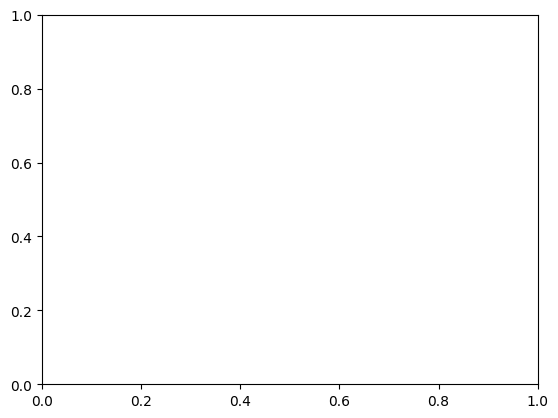

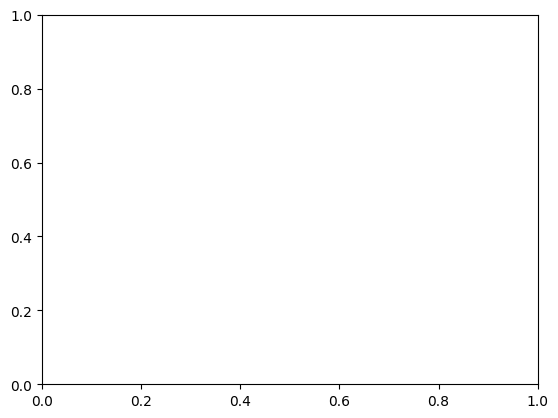

In [261]:
print("Number of parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

idx1 = np.random.randint(0,20)
idx2 = np.random.randint(0,256)
fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()

ax.plot(generated_image[idx1, nx,ny][-50:])
ax.plot(test_snapshots[trajectory, idx1, nx, ny][-50:])
ax.legend(["Ground Truth", "Generated Sample"])
rel_error = 100 * np.abs((test_snapshots[trajectory, :,  nx, ny].T - generated_image[..., nx, ny])/test_snapshots[trajectory, :, nx, ny].T)
print(rel_error.shape)
ax2.plot(rel_error[idx1, -50:])

#print(generated_image.shape)
print(np.mean(rel_error))
#plt.plot(rel_error[5, 30:100])
#plt.plot(np.mean(test_snapshots[trajectory, :,  nx, ny], axis=-1).shape)

In [18]:
K = 1
steps = np.ones((K,), dtype=np.int16) * 100#
idx =  np.random.randint(0, 20)
snapshot = test_snapshots[trajectory,idx]
print(sparse_measurement.shape)

sparse_measurement_sample = sparse_measurement[idx].unsqueeze(0)
print(sparse_measurement_sample.shape)

enforced_measurements = []
n = 100
idx_sparse_measurement = np.random.randint(0,100)
for i in range(n):
    generated_image = denoise(sparse_measurement_sample, model,steps=steps, K=1, beta_max=0.02, output_freq=10, show_intermediate_output=False).squeeze().detach().cpu().numpy()
    enforced_measurements.append(generated_image[nx,ny][idx_sparse_measurement: idx_sparse_measurement + 50])
enforced_measurements = np.array(enforced_measurements)


torch.Size([20, 1, 256, 256])
torch.Size([1, 1, 256, 256])


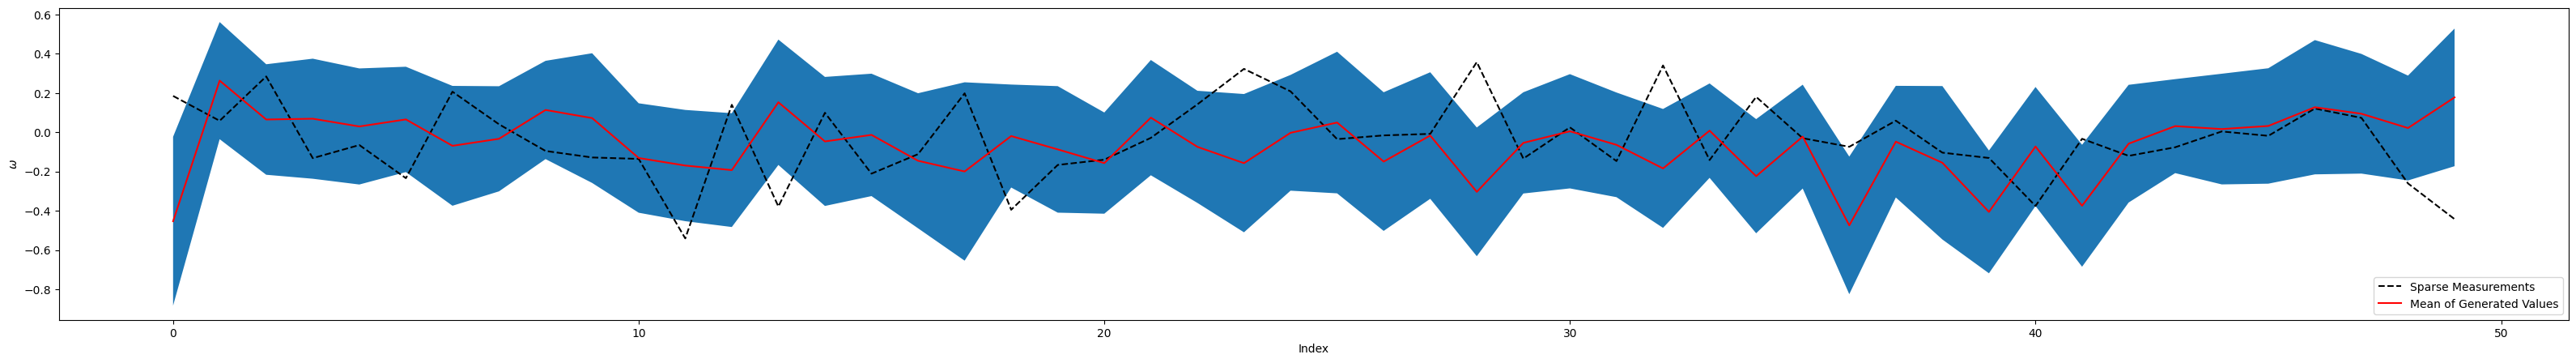

In [19]:
mean = np.mean(enforced_measurements, axis=0)
std = np.std(enforced_measurements, axis=0)
plt.figure(figsize=(40,5))
plt.plot(snapshot[nx,ny][:50], "--", color="k")
plt.plot(mean, color="red")
plt.fill_between(np.arange(50), mean- 3*std, mean+ 3*std)
plt.xlabel("Index")
plt.ylabel(r"$\omega$")
plt.legend(["Sparse Measurements", "Mean of Generated Values"])
plt.savefig("plots/uncertainty.png", dpi=400)